## Objective: to create a baseline content-based recommender system using TF-IDF vectorizer and cosine similarity

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from joblib import dump
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_colwidth', None)  


In [49]:
print(pd.__version__)

2.3.0


### Read the news article dataset into a pandas dataframe and sample 10k rows

In [50]:
news_df = pd.read_csv('news.tsv', sep='\t', header = None)
news_df.columns = ["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]

news_df = news_df.sample(n=10000, random_state=42) #randomly sample 10k rows from the news articles dataset
news_df.reset_index(drop = True, inplace = True)


### Explore dataset and check for missing values and duplicates

In [51]:
news_df.info() #10K unique articles


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   news_id            10000 non-null  object
 1   category           10000 non-null  object
 2   subcategory        10000 non-null  object
 3   title              10000 non-null  object
 4   abstract           9470 non-null   object
 5   url                10000 non-null  object
 6   title_entities     9999 non-null   object
 7   abstract_entities  9999 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [52]:
news_df.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N7433,news,newsus,The 3 best Greek spots in Aurora,Hoodline crunched the numbers to find the top Greek spots around Aurora. Here's a rundown of three of the top places.,https://assets.msn.com/labs/mind/BBWHLdc.html,[],[]
1,N43326,sports,more_sports,Officials investigating stabbing death of Alexander Correctional Institute inmate,NaN,https://assets.msn.com/labs/mind/AAJD8WV.html,"[{""Label"": ""Prison"", ""Type"": ""C"", ""WikidataId"": ""Q40357"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [52], ""SurfaceForms"": [""Correctional Institute""]}]",[]
2,N45745,finance,finance-top-stocks,"SmileDirectClub tanks on California bill, bringing loss since September IPO to nearly 60%",Shares of SmileDirectClub sank to a new all-time low during Monday's trading session after a California bill regulating the dental industry was extended through 2024.,https://assets.msn.com/labs/mind/AAILU2e.html,"[{""Label"": ""SmileDirectClub"", ""Type"": ""N"", ""WikidataId"": ""Q60751931"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""SmileDirectClub""]}, {""Label"": ""Initial public offering"", ""Type"": ""U"", ""WikidataId"": ""Q185142"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [72], ""SurfaceForms"": [""IPO""]}]","[{""Label"": ""SmileDirectClub"", ""Type"": ""N"", ""WikidataId"": ""Q60751931"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [10], ""SurfaceForms"": [""SmileDirectClub""]}]"
3,N5234,travel,traveltips,The world's 50 most reliable airlines,"No one wants to kick off their holiday with delays, cancellations or bad customer service, so if you're keen for your next journey to be smooth sailing or smooth flying, rather travel insurance provider Get Going Travel Insurance has got you covered. They've examined the reliability of more than 100 of the world's airlines, looking at the percentage of cancellations and delays, as well as customer and safety ratings, and ranked the top 50 from worst to best. Here's our lowdown on the results.",https://assets.msn.com/labs/mind/AAJub6N.html,[],"[{""Label"": ""Get Going"", ""Type"": ""N"", ""WikidataId"": ""Q62076002"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [207], ""SurfaceForms"": [""Get Going""]}, {""Label"": ""Travel insurance"", ""Type"": ""U"", ""WikidataId"": ""Q1270407"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [181, 217], ""SurfaceForms"": [""travel insurance"", ""Travel Insurance""]}]"
4,N58530,sports,basketball_ncaa,High school football: Breaking down the Class 3A playoff bracket,"The Class 3A football playoffs begin Friday across the state. Here is a breakdown of the bracket. Player to watch Chase Ricke, Lincoln Christian The senior quarterback has been phenomenal this season. He has led an offense that is averaging 51 points per contest and could lead the Bulldogs to an upset against Heritage Hall in the semifinals. Team to watch Perkins-Tryon The Demons' ...",https://assets.msn.com/labs/mind/BBWAERc.html,"[{""Label"": ""South African Class 3A 4-8-2"", ""Type"": ""V"", ""WikidataId"": ""Q1722959"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [40], ""SurfaceForms"": [""Class 3A""]}]","[{""Label"": ""Heritage Hall School"", ""Type"": ""F"", ""WikidataId"": ""Q5738839"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [311], ""SurfaceForms"": [""Heritage Hall""]}, {""Label"": ""South African Class 3A 4-8-2"", ""Type"": ""V"", ""WikidataId"": ""Q1722959"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [4], ""SurfaceForms"": [""Class 3A""]}]"


In [53]:
news_df = news_df[['news_id', 'category', 'subcategory', 'title', 'abstract', 'title_entities', 'abstract_entities']]

In [54]:
news_df.isna().sum()

news_id                0
category               0
subcategory            0
title                  0
abstract             530
title_entities         1
abstract_entities      1
dtype: int64

In [55]:
news_df[news_df['abstract'].isna()]

,news_id,category,subcategory,title,abstract,title_entities,abstract_entities
1,N43326,sports,more_sports,Officials investigating stabbing death of Alexander Correctional Institute inmate,NaN,"[{""Label"": ""Prison"", ""Type"": ""C"", ""WikidataId"": ""Q40357"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [52], ""SurfaceForms"": [""Correctional Institute""]}]",[]
5,N60943,news,newsus,"Car trailer hauling 5 vehicles, including Porsche, stolen in the Bronx",NaN,"[{""Label"": ""The Bronx"", ""Type"": ""G"", ""WikidataId"": ""Q18426"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [65], ""SurfaceForms"": [""Bronx""]}, {""Label"": ""Porsche"", ""Type"": ""O"", ""WikidataId"": ""Q40993"", ""Confidence"": 0.997, ""OccurrenceOffsets"": [42], ""SurfaceForms"": [""Porsche""]}]",[]
15,N37781,news,newscrime,Police: Man shot friend in head with shotgun during argument over LSU-Alabama game,NaN,[],[]
16,N61444,finance,financenews,"Plan to close Lordstown facility moves forward with GM, UAW agreement; contract ratification under way",NaN,"[{""Label"": ""Lordstown, Ohio"", ""Type"": ""G"", ""WikidataId"": ""Q1816711"", ""Confidence"": 0.999, ""OccurrenceOffsets"": [14], ""SurfaceForms"": [""Lordstown""]}, {""Label"": ""United Automobile Workers"", ""Type"": ""O"", ""WikidataId"": ""Q1814260"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [56], ""SurfaceForms"": [""UAW""]}]",[]
36,N9246,news,newscrime,"Woman broke into cars, stole credit cards and bought Visa gift cards, police say",NaN,"[{""Label"": ""Visa Inc."", ""Type"": ""O"", ""WikidataId"": ""Q328840"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [53], ""SurfaceForms"": [""Visa""]}]",[]
...,...,...,...,...,...,...,...
9881,N35839,foodanddrink,newstrends,Three Sickened After Eating Tuna At Seattle Restaurant,NaN,"[{""Label"": ""Tuna"", ""Type"": ""J"", ""WikidataId"": ""Q6146274"", ""Confidence"": 0.991, ""OccurrenceOffsets"": [28], ""SurfaceForms"": [""Tuna""]}]",[]
9893,N49826,news,newsus,Suspects wanted in violent robbery of food delivery man in Brooklyn,NaN,"[{""Label"": ""Brooklyn"", ""Type"": ""G"", ""WikidataId"": ""Q18419"", ""Confidence"": 0.983, ""OccurrenceOffsets"": [59], ""SurfaceForms"": [""Brooklyn""]}]",[]
9917,N9029,sports,football_ncaa,Louisiana governor waits until end of LSU-Florida to make post-election speech,NaN,"[{""Label"": ""Louisiana"", ""Type"": ""G"", ""WikidataId"": ""Q1588"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [0], ""SurfaceForms"": [""Louisiana""]}]",[]
9972,N30289,news,newsus,Community rally planned after 3 senior citizens attacked in San Francisco's Chinatown,NaN,"[{""Label"": ""Chinatown, San Francisco"", ""Type"": ""G"", ""WikidataId"": ""Q1073644"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [60], ""SurfaceForms"": [""San Francisco's Chinatown""]}]",[]


In [56]:
news_df.duplicated().sum() #output shows there are no duplicates

0

In [57]:
news_df.dropna(inplace = True) # Drop any rows with missing values

In [58]:
news_df.shape

(9469, 7)

In [59]:
#transform the title and abstract columns into list of words

news_df['title_cleaned'] = news_df['title'].apply(lambda x: x.split())
news_df['abstract'] = news_df['abstract'].apply(lambda x: x.split())

In [60]:
#create helper function to extract the labels and surface forms from the title_entities and abstract
import ast

def extract_entities(ent_list: str) -> list:
    master_list = []
    for item in ast.literal_eval(ent_list):
        master_list.append(item["Label"])
        if item["SurfaceForms"]:
            master_list.append(item["SurfaceForms"][0])
    
    return list(set(master_list))
    

In [61]:
news_df['title_entities'] = news_df['title_entities'].apply(extract_entities)
news_df['abstract_entities'] = news_df['abstract_entities'].apply(extract_entities)


In [62]:
cols = ['title_cleaned', 'abstract', 'title_entities', 'abstract_entities']

for i in cols:
    news_df[i] = news_df[i].apply(lambda x: [i.lower().replace(' ', '') for i in x])


### Create a tags column that is a combination of keywords from title , category, subcategory, and abstract for TF-IDF vectorizer

In [63]:
news_df['tags'] = news_df['title_cleaned'] + news_df['abstract'] +news_df['title_entities'] + news_df['abstract_entities']

In [64]:
news_df['tags'] = news_df.apply(lambda row: row['tags'] + [row['category']] + [row['subcategory']], axis=1)


In [65]:
news_df['tags'].apply(len).sort_values(ascending=False)


2685    371
1340    342
5440    276
3096    252
8881    245
       ... 
7443      8
3967      8
1049      8
9707      7
3783      7
Name: tags, Length: 9469, dtype: int64

In [66]:
news_df.reset_index(drop = True, inplace = True)


In [67]:
news_df['tags'] = news_df['tags'].apply(lambda x: ' '.join(x))


### Import TF-IDF vectorizer and cosine similarity + find good value for max number of features (hyperparameter tuning) for TF-IDF

In [68]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


In [69]:
max_features_range = [100, 500, 1000, 3000, 5000, 10000, 30000, 50000, None]


X_text = news_df['tags']
results = []

for mf in max_features_range:
    tfidf = TfidfVectorizer(max_features=mf, stop_words = 'english')
    X_tfidf = tfidf.fit_transform(X_text)

    sim_matrix = cosine_similarity(X_tfidf)
    sim_vals = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]  
    var = np.var(sim_vals) #look at cosine similarity variance -> higher variance is generally better
    results.append((mf, var))
    print(f"max_features={mf}, cosine sim variance={var:.6f}")

best = max(results, key=lambda x: x[1])
print(f"\n Best max_features: {best[0]} with cosine sim variance: {best[1]:.6f}")




max_features=100, cosine sim variance=0.013773
max_features=500, cosine sim variance=0.003270
max_features=1000, cosine sim variance=0.001840
max_features=3000, cosine sim variance=0.000834
max_features=5000, cosine sim variance=0.000603
max_features=10000, cosine sim variance=0.000419
max_features=30000, cosine sim variance=0.000291
max_features=50000, cosine sim variance=0.000277
max_features=None, cosine sim variance=0.000277

 Best max_features: 100 with cosine sim variance: 0.013773


In [70]:
mf = [100, 500, 1000, 3000, 5000, 10000, 30000, 50000]

for i in mf:
    tfidf = TfidfVectorizer(max_features= i, stop_words='english')
    X_tfidf = tfidf.fit_transform(X_text)
    density = X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])
    print(f"Density at {i} features: {density:.6f}")


Density at 100 features: 0.047675
Density at 500 features: 0.019735
Density at 1000 features: 0.013037
Density at 3000 features: 0.006183
Density at 5000 features: 0.004179
Density at 10000 features: 0.002362
Density at 30000 features: 0.000896
Density at 50000 features: 0.000737


### Choose 1000 as max_features 

In [71]:
max_features = 1000
vec = TfidfVectorizer(max_features= max_features, stop_words = 'english')

tfidf_matrix = vec.fit_transform(news_df['tags'])
#print(tfidf_matrix.toarray())

In [72]:
tfidf_matrix.shape

(9469, 1000)

In [73]:
features = vec.get_feature_names_out()
print(features)

['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '2017'
 '2018' '2019' '2020' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '35' '40' '49ers' '50' '500' '60' '75' 'able' 'accident' 'according'
 'accused' 'action' 'actually' 'adam' 'added' 'administration' 'afternoon'
 'agency' 'ago' 'ahead' 'air' 'airport' 'alabama' 'allegedly' 'amazon'
 'america' 'american' 'americanfootball' 'amid' 'angeles' 'animal'
 'animals' 'announced' 'annual' 'anthony' 'anti' 'antonio' 'ap'
 'apartment' 'apartments' 'appeared' 'apple' 'area' 'aren' 'arizona'
 'arlington' 'arrested' 'arrived' 'art' 'asked' 'assault'
 'associatedpress' 'astros' 'atlanta' 'attack' 'attorney' 'austin'
 'authorities' 'autos' 'autosnews' 'available' 'avenue' 'awards' 'away'
 'baby' 'bad' 'ball' 'baltimore' 'baltimoreravens' 'bar' 'baseball'
 'baseball_mlb' 'based' 'basketball' 'basketball_nba' 'basketball_ncaa'
 'bay' 'beach' 'bears' 'beat' 'began' 'begin' 'believe' 'bengals' 'best'
 'better' 'biden' 'big

### rerun TF-IDF vectorization on stemmed tokens

In [74]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def get_word_stem(obj):
    stem_list = []
    for i in obj.split():
        stem_list.append(ps.stem(i))
    return ' '.join(stem_list)

news_df['tags'] = news_df['tags'].apply(get_word_stem)

In [75]:
vec = TfidfVectorizer(max_features=1000, stop_words = 'english')

tfidf_matrix = vec.fit_transform(news_df['tags'])

In [76]:
features = vec.get_feature_names_out()
print(features)

['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '2017'
 '2018' '2019' '2020' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '35' '40' '49er' '50' '500' '60' 'abl' 'accid' 'accord' 'accus' 'act'
 'action' 'actual' 'ad' 'adam' 'administr' 'afternoon' 'agent' 'ago'
 'ahead' 'air' 'airport' 'alabama' 'alleg' 'allow' 'alreadi' 'alway'
 'amazon' 'america' 'american' 'americanfootball' 'amid' 'angel' 'ani'
 'anim' 'announc' 'annual' 'anoth' 'answer' 'antonio' 'ap' 'apart' 'app'
 'appear' 'area' 'arizona' 'arrest' 'arriv' 'art' 'ask' 'assault' 'assist'
 'associatedpress' 'astro' 'atlanta' 'attack' 'attempt' 'attend'
 'attorney' 'austin' 'author' 'auto' 'autosnew' 'avenu' 'avoid' 'award'
 'away' 'babi' 'bad' 'ball' 'baltimor' 'baltimoreraven' 'bar' 'bas' 'base'
 'baseball_mlb' 'basketbal' 'basketball_nba' 'basketball_ncaa' 'battl'
 'bay' 'beach' 'bear' 'beat' 'becaus' 'becom' 'befor' 'begin' 'believ'
 'bengal' 'best' 'better' 'biden' 'big' 'biggest' 'black' 'block' 'blue

In [77]:
similarity = cosine_similarity(tfidf_matrix) #run cosine similarity on the new tf-idf matrix 


### Model: output the 5 most similar articles to the input article

In [78]:
def recommend_articles(article):
    article_index = news_df[news_df['title'] == article].index[0]
    similarity_scores = similarity[article_index]
    article_list = sorted(list(enumerate(similarity[article_index])),reverse = True, key=lambda x: x[1])[1:6]
    print(article_list)
    for i in article_list:
        print(news_df.iloc[i[0]].title)
    

In [79]:

news_df.title[:100]

0                                                              The 3 best Greek spots in Aurora
1     SmileDirectClub tanks on California bill, bringing loss since September IPO to nearly 60%
2                                                         The world's 50 most reliable airlines
3                              High school football: Breaking down the Class 3A playoff bracket
4                                 At a UFC event, Trump receives second round of boos in a week
                                                ...                                            
95                                                 Colts nearly drafted CB Champ Bailey in 1999
96                 38 men who were worthy competitors for John Legend's Sexiest Man Alive title
97                                                            Tons of Tubers Dropped in Lemoyne
98                                               Trio wins economics Nobel for fighting poverty
99                                AMBER 

In [80]:
article = "The 3 best Greek spots in Aurora"
news_df[news_df['title'] == article]

,news_id,category,subcategory,title,abstract,title_entities,abstract_entities,title_cleaned,tags
0,N7433,news,newsus,The 3 best Greek spots in Aurora,"[hoodline, crunched, the, numbers, to, find, the, top, greek, spots, around, aurora., here's, a, rundown, of, three, of, the, top, places.]",[],[],"[the, 3, best, greek, spots, in, aurora]",the 3 best greek spot in aurora hoodlin crunch the number to find the top greek spot around aurora. here' a rundown of three of the top places. news newsu


In [81]:
inp_id = news_df.loc[news_df['title'] == article, 'news_id'].values[0]
news_df[news_df['news_id'] == inp_id].tags

0    the 3 best greek spot in aurora hoodlin crunch the number to find the top greek spot around aurora. here' a rundown of three of the top places. news newsu
Name: tags, dtype: object

In [82]:
recommend_articles(article)

[(9003, 0.7750322902383374), (1711, 0.7316539128578328), (1881, 0.6747760070070389), (2753, 0.6707953233924896), (3369, 0.5896095896916413)]
Here are Minneapolis' top 5 used, vintage and consignment spots
The 4 best Mexican spots in Norfolk
NASA Spacecraft Spots A Strange Bright Spot On Jupiter
Here are Norfolk's top 4 French spots
The 3 best gyms in Aurora


In [83]:
article = "Colts nearly drafted CB Champ Bailey in 1999"
recommend_articles(article)

[(3377, 0.622208832393952), (4316, 0.5425686132763836), (542, 0.5055672168784461), (1487, 0.41403465171625703), (4233, 0.3266760772456565)]
CBS staffer fired over Robach tape says she wasn't the one to leak it
CBS To Remake James Corden's Sky Gameshow 'A League Of Their Own'
Gary McCord speaks out loudly about being dropped from CBS golf team: 'Bottom line, they fired me'
Browns at Broncos: TV broadcast map for Week 9
Eye Opener 8: Jimmy Carter undergoing brain procedure


In [84]:
news_df['category'].value_counts()

category
news             2947
sports           2586
finance           563
foodanddrink      486
lifestyle         454
travel            447
video             400
health            384
weather           354
autos             293
tv                197
music             148
movies            110
entertainment      95
kids                4
middleeast          1
Name: count, dtype: int64

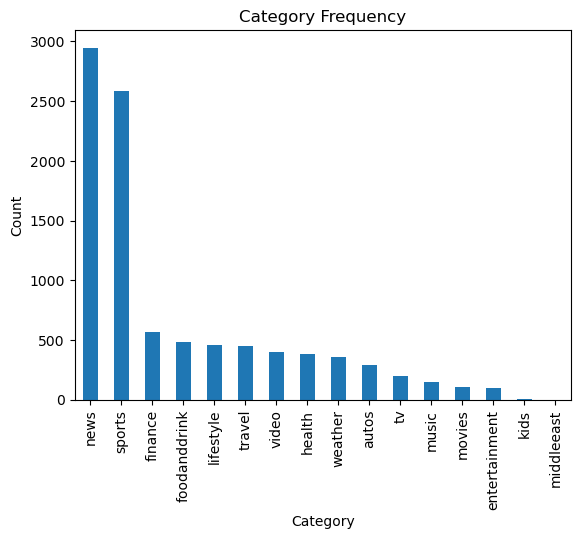

In [85]:
news_df['category'].value_counts().plot(kind = 'bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Frequency')
plt.show()

### Updated Model: output the 5 most similar articles in the same category as the input article 

In [86]:
def recommend_articles_within_category(article):
    
    article_index = news_df[news_df['title'] == article].index[0]
    category = news_df.loc[news_df['title'] == article, 'category'].values[0]
    similarity_scores = similarity[article_index]
    same_category_article_indices = news_df[news_df['category'] == category].index
    #filter out articles that are not in the same category as the input
    article_list = sorted(list(enumerate(similarity[article_index])), reverse = True, key=lambda x: x[1])
    filtered_list = [i for i in article_list if i[0] in same_category_article_indices][1:6]
    print(filtered_list)
        
    for i in filtered_list:
        print(category, news_df.iloc[i[0]].title)

In [87]:
category = news_df.loc[news_df['title'] == article, 'category'].values[0]

In [88]:
news_df[news_df['category'] == category].index

Index([   3,    6,    8,   10,   20,   21,   32,   35,   38,   42,
       ...
       9431, 9436, 9437, 9441, 9442, 9447, 9448, 9449, 9466, 9467],
      dtype='int64', length=2586)

### Test and Save models

In [89]:
article = "The 3 best Greek spots in Aurora"
recommend_articles_within_category(article)

[(9003, 0.7750322902383374), (3369, 0.5896095896916413), (6980, 0.5448472712962079), (11, 0.5064644520857159), (3020, 0.4650951125972894)]
news Here are Minneapolis' top 5 used, vintage and consignment spots
news The 3 best gyms in Aurora
news Here are Berkeley's top 5 cards and stationery spots
news New Pioneer Square Vietnamese spot, Mr Saigon opens its doors
news The 4 best vegan spots in Detroit


In [90]:
article = "AMBER Alert issued for 2-year-old girl from Miami-Dade County"
recommend_articles_within_category(article)

[(4347, 0.6520276393026079), (9026, 0.6506248237584491), (6068, 0.6345519081497022), (4428, 0.6102795713132387), (3215, 0.5368079495957709)]
news In three Miami-Dade cities, the election isn't over. Here's how to vote in the runoff.
news Miami man robbed gas stations and convenience stores, FBI says, and it may be a federal case
news Dead cats are popping up at a Miami-Dade condominium. Residents think it's poison.
news He wants to control rent and steal a trolley. He's running for Miami's District 1.
news Miami-Dade has hundreds of illegal Airbnbs. Now county wants to water down rules


In [91]:
news_df[(news_df['category'] == 'health') & (news_df['title'].str.contains('derm', case = False))]

,news_id,category,subcategory,title,abstract,title_entities,abstract_entities,title_cleaned,tags
1944,N38324,health,medical,"How to Get Rid of Skin Tags, According to a Dermatologist","[they, seem, harmless,, but, there's, a, very, good, reason, you, shouldn't, ignore, them., the, post, how, to, get, rid, of, skin, tags,, according, to, a, dermatologist, appeared, first, on, reader's, digest.]","[skintag, skintags]","[dermatologist, reader'sdigest, dermatology, skintag, skintags]","[how, to, get, rid, of, skin, tags,, according, to, a, dermatologist]","how to get rid of skin tags, accord to a dermatologist they seem harmless, but there' a veri good reason you shouldn't ignor them. the post how to get rid of skin tags, accord to a dermatologist appear first on reader' digest. skintag skintag dermatologist reader'sdigest dermatolog skintag skintag health medic"
4914,N13489,health,health-news,"New Schizophrenia Drug Approved by FDA, Will Be Available as Transdermal Patch","[a, transdermal, patch, that, could, bring, relief, to, people, with, schizophrenia, has, been, approved, by, the, fda.]","[transdermalpatch, fda, foodanddrugadministration, transdermalpatch]","[transdermalpatch, fda, foodanddrugadministration, transdermalpatch]","[new, schizophrenia, drug, approved, by, fda,, will, be, available, as, transdermal, patch]","new schizophrenia drug approv by fda, will be avail as transderm patch a transderm patch that could bring relief to peopl with schizophrenia ha been approv by the fda. transdermalpatch fda foodanddrugadministr transdermalpatch transdermalpatch fda foodanddrugadministr transdermalpatch health health-new"


In [92]:
dump(news_df, 'news_df.joblib')

['news_df.joblib']

In [93]:
filename = 'news_df.joblib'

# Get absolute path
absolute_path = os.path.abspath(filename)


In [94]:
dump(similarity, 'similarity.joblib')

['similarity.joblib']